# kriging_est関数とRの結果を比較する
- 推定結果が大きく異なってしまう原因を探る
- cvを行う

In [1]:
import sys
sys.path.append('/Users/LOng/sengokulab/LDAT_LS_2019/scripts/')

In [270]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calc_variogram as variogram
import kriging_est as kriging

In [3]:
%load_ext autoreload
%autoreload 2

In [271]:
# 前処理
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
data['price'] = np.log(data.price)

In [272]:
data_list = [data.drop(i) for i in range(0, 128)]
mdat_list = [data.loc[i] for i in range(0, 128)]

# 1行目をleaveしてLOO

In [483]:
data = data_list[0]

## Step1: OLSから残差を算出

In [484]:
x = data[['station', 'tokyo']]
y = data['price']

In [485]:
step1 = sm.OLS(y, x)
step1_res = step1.fit()
resid = step1_res.resid

## Step2: 残差からvariogramを推定

In [486]:
# 前処理
resid = pd.DataFrame(resid, columns=['residuals'])
resid = data[['px', 'py']].join(resid)
resid = resid.values

In [487]:
vario = variogram.get_diff(resid)

In [9]:
'''
# 前処理
resid = pd.DataFrame(resid, columns=['residuals'])
resid = data[['px', 'py']].join(resid)
resid = resid.values
'''

In [136]:
'''
a = pd.DataFrame(np.vstack([counts, bins, e_vario])).T
a.columns = ['np', 'dist', 'gamma']
print(a)
'''

       np      dist     gamma
0   102.0  0.006568  0.073519
1   249.0  0.011453  0.230082
2   308.0  0.016338  0.304647
3   342.0  0.021223  0.435664
4   381.0  0.026109  0.541231
5   364.0  0.030994  0.710059
6   411.0  0.035879  0.860014
7   371.0  0.040764  1.008774
8   374.0  0.045649  1.292671
9   375.0  0.050534  1.411508
10  379.0  0.055419  1.532603
11  388.0  0.060304  1.722532
12  383.0  0.065189  1.742802
13  386.0  0.070074  1.878569
14  373.0  0.074959  1.859373


[0.         0.00457977 0.00915954 0.01373932 0.01831909 0.02289886
 0.02747863 0.03205841 0.03663818 0.04121795]
[0.         0.00457977 0.00915954 0.01373932 0.01831909 0.02289886
 0.02747863 0.03205841 0.03663818 0.04121795] 0.027388854645603075


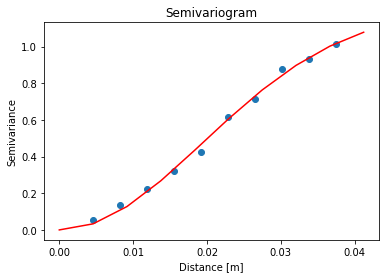

In [541]:
param, lag, fig = variogram.auto_vario(vario, 10, 1, plot=True)

In [542]:
print(param)

[1.00000000e+00 1.00000000e+02 1.20304763e+00 2.73888546e-02]


## Step3: gls
- 共分散関数を推定
    - 観測値間の距離行列を作成
    - 推定したパラメータから$\hat{C}(0)$を推定
    - 正定値になるように処理を加える(数学的な根拠は不明, Rではどのように処理している?)
- 共分散関数の推定量を用いてgls

In [543]:
distance_mat = kriging.calc_distance_matrix(data, ['px', 'py'])

In [544]:
efrange, c0 = kriging.calc_c0(param, distance_mat)

In [545]:
print(efrange)

0.0474388878073034


In [546]:
print(c0)

0.05989621450935761


In [547]:
# 距離行列と関数形から共分散関数を求める
# reg=Trueなので正定値化処理を加えている
covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)

1.1432514129586873


In [548]:
print(covariance_mat)

[[1.20314763e+00 2.48790204e-04 7.89901240e-04 ... 2.08148630e-12
  6.19149885e-13 1.48033826e-12]
 [2.48790204e-04 1.20314763e+00 1.12567998e+00 ... 1.75676647e-06
  9.28891407e-07 8.14307400e-07]
 [7.89901240e-04 1.12567998e+00 1.20314763e+00 ... 3.29357245e-06
  1.70270729e-06 1.63384809e-06]
 ...
 [2.08148630e-12 1.75676647e-06 3.29357245e-06 ... 1.20314763e+00
  1.18664714e+00 1.17845982e+00]
 [6.19149885e-13 9.28891407e-07 1.70270729e-06 ... 1.18664714e+00
  1.20314763e+00 1.16362470e+00]
 [1.48033826e-12 8.14307400e-07 1.63384809e-06 ... 1.17845982e+00
  1.16362470e+00 1.20314763e+00]]


In [549]:
# 重みを用いてgls
# statsmodelsのresultクラスが返る
res, resid = kriging.do_gls(y, x, covariance_mat)

In [550]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.397
Model:                            GLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     41.16
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           1.85e-14
Time:                        16:44:34   Log-Likelihood:                -20.294
No. Observations:                 127   AIC:                             44.59
Df Residuals:                     125   BIC:                             50.28
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
station      -16.8348      3.559     -4.730      0.000     -23.879      -9.790
tokyo         34.6983      4.455      7.788      0.000      25.881      43.516
==============================================================================
Omnibus:                        9.084   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               19.247
Skew:                          -0.111   Prob(JB):                     6.62e-05
Kurtosis:                       4.894   Cond. No.                         1.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step4: kirigng
- 観測地点と予測地点の間の共分散関数$c_*$を作成する
    - 距離行列作成
    - 共分散関数にあてはめる
- 足し合わせ $\hat{Y}(s_o) = X(s_0)\hat{\beta}_{gls} + c_*'\hat{\Sigma}^{-1}(Y - X\beta)$

In [551]:
mdat = mdat_list[0]

In [552]:
mpoints = mdat[['px', 'py']].values
mexog = mdat[['station', 'tokyo']].values
points = data[['px', 'py']].values

In [553]:
mpoints = mpoints.reshape(1,2)

In [554]:
# 距離行列作成
new_dist_mat = kriging.calc_distance_new_data(mpoints, points)

In [555]:
# 距離行列と関数型から共分散行列を推定
# reg=Falseを指定して正定値処理をスキップ(正方行列でないのでエラーを防ぐ)
c_mat = kriging.est_covariance_matrix(new_dist_mat, param, c0, reg=False)

In [556]:
fitted_val = kriging.put_pred_val(res, mexog)

In [557]:
kriging_val = kriging.do_kriging(fitted_val, c_mat, covariance_mat, resid)

In [558]:
kriging_val - mdat['price']

array([2.66538058])

# CVを関数化する

In [559]:
obs = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')

In [560]:
price = np.log(obs.price.values)

In [562]:
pred_list = []
for i in range(0, 128):
    data = data_list[i]
    mdat = mdat_list[i]
    
    x = data[['station', 'tokyo']]
    y = data['price']
    step1 = sm.OLS(y, x)
    step1_res = step1.fit()
    resid = step1_res.resid
    # 前処理
    resid = pd.DataFrame(resid, columns=['residuals'])
    resid = data[['px', 'py']].join(resid)
    resid = resid.values
    
    vario = variogram.get_diff(resid)
    param, lag, fig = variogram.auto_vario(vario, 10, 1, plot=False)
    
    distance_mat = kriging.calc_distance_matrix(data, ['px', 'py'])
    efrange, c0 = kriging.calc_c0(param, distance_mat)
    covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)
    res, resid = kriging.do_gls(y, x, covariance_mat)
    
    mpoints = mdat[['px', 'py']].values.reshape(1, 2)
    mexog = mdat[['station', 'tokyo']].values
    points = data[['px', 'py']].values
    new_dist_mat = kriging.calc_distance_new_data(mpoints, points)
    c_mat = kriging.est_covariance_matrix(new_dist_mat, param, c0, reg=False)
    
    fitted_val = kriging.put_pred_val(res, mexog)
    kriging_val = kriging.do_kriging(fitted_val, c_mat, covariance_mat, resid)
    
    diff1 = np.abs(price[i] - fitted_val)
    diff2 = np.abs(price[i] - kriging_val)
    
    if diff1 >= diff2:
        pred_list.append(kriging_val)
    else:
        pred_list.append(fitted_val)

1.0122932814228383
1.0531436984570735
1.0740200532295097
1.0795822946999571
1.054403115614489
1.1215283887986136
1.0676351465202454
1.0806034801626982
1.1106885175485874
1.098975913322187
1.074524595629864
1.0787599828508503
1.1031434408786915
1.1050214475536122
1.0978501934526572
1.0951246772866947
1.0958690032860783
1.0919387127192544
1.1061292531541895
1.1401089316920217
1.0762077556954965
1.1378427768378356
1.1194445673785034
1.1136917458596425
1.1470623806159648
1.1294321238046514
1.1096419490704246
1.1241227852527689
1.1250976116255493
1.1019837838563804
1.126202316318978
1.1327656716372931
1.1321245918704625
1.1301925251746725
1.132292768358183
1.1289192439903162
1.1348810578641302
1.1162552730563844
1.1368153860264256
1.1298788835672342
1.134924046083019
1.1285226461968139
1.141874862685842
1.1273754136694862
1.137537698988541
1.1178058519771727
1.1336464150566954
1.1308689162684327
1.1253182287278942
1.1238153781178088
1.1197296048151022
1.1043184278186555
1.145839623352857
1.

Text(0.5, 1.0, 'Prediction of housing price(log) by hand made functions')

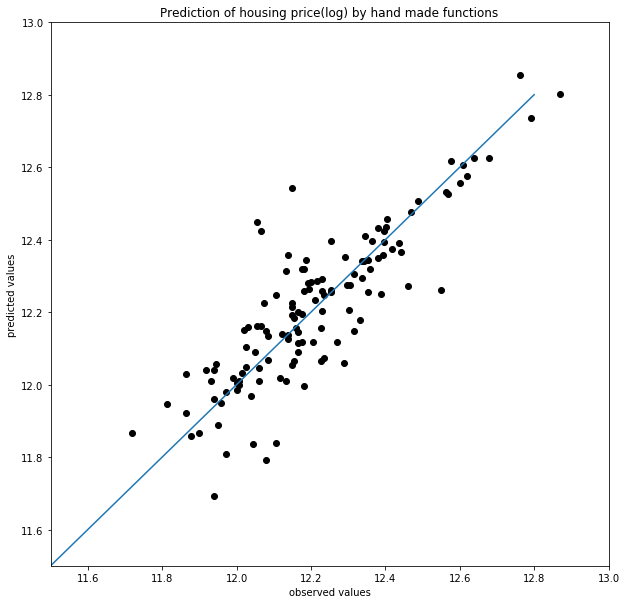

In [563]:
lim = [11.5, 13]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(price, pred_list, color='black')
ax.plot(np.linspace(11.5, 12.8, 100), np.linspace(11.5, 12.8, 100))
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_xlabel('observed values')
ax.set_ylabel('predicted values')
ax.set_title('Prediction of housing price(log) by hand made functions')

In [259]:
from sklearn.metrics import mean_squared_error

In [564]:
np.sqrt(mean_squared_error(price, np.array(pred_list)))

0.11432694731734837

In [261]:
fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_cv.png')